In [10]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
import networkx as nx
from networkx.algorithms import bipartite
%matplotlib inline

First, we load the csv file. As the "white" parameter is not present, we add add a column "white" so that we can take this parameter into consideration. As written is the Dataset description, there is only three color skin categories: "white", "hispanic" and "black". So we define as "white" all the subjects that are neither hispanic nor black.

In [11]:
df = pd.read_csv("./lalonde.csv")
df['white'] = ((df['hispan'] == 0) & (df['black'] == 0)).astype(int)

As a naive approach, we calculate the mean and the standard deviation of the real earnings in 1978 for both the control group and the treatment group.

In [13]:
df_treat_0 = df[df['treat'] == 0]
mean_0 = df_treat_0['re78'].mean()
std_0 = df_treat_0['re78'].std()
df_treat_1 = df[df['treat'] == 1]
mean_1 = df_treat_1['re78'].mean()
std_1 = df_treat_1['re78'].std()

print("For control group:\nMean =", mean_0, "\nStandard Deviation =", std_0)
print("\nFor treatment group:\nMean =", mean_1, "\nStandard Deviation =", std_1)

For control group:
Mean = 6984.169742307697 
Standard Deviation = 7294.161790868392

For treatment group:
Mean = 6349.143530270269 
Standard Deviation = 7867.402217734684


With these results, we could assess that the training program is not efficient and did not increase the real earnings for the subjects who participated in it. However we know that mean and standard deviations are not strong indicators and can be influenced by outliers. So we're gonna use stronger tools to assess the efficiency of the training program.

We can plot a histogram of the real earnings in 1978 for both groups to have an overview of the repartition and to notice if outliers are present in the dataset

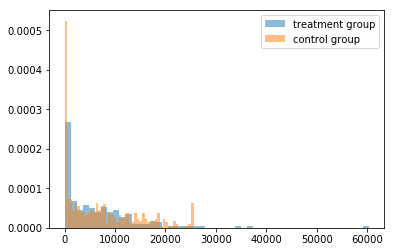

In [24]:
plt.hist(df_treat_1['re78'], bins = 50, alpha = 0.5,normed=True)
plt.hist(df_treat_0['re78'], bins = 50, alpha = 0.5,normed=True)
plt.legend(['treatment group','control group'])

We see that indeed, there are some outliers that could have influenced our mean and std values.

To get a more robust analysis, we can use strong statistic tools such as median and quantiles.

In [15]:
re78_1 = df_treat_1['re78']
re78_0 = df_treat_0['re78']
print("Median of real earnings in 1978:")
print("For people who did not participate in the job training program: ",re78_0.median())
print("For people who participated in the job training program: ", re78_1.median())

Median of real earnings in 1978:
For people who did not participate in the job training program:  4975.505
For people who participated in the job training program:  4232.309


We see that the median for the real earnings in 1978 is higher for people who did not participate in the training program. It seems that the training has no effect (or is even a factor of decreasing in the real earnings people can make).

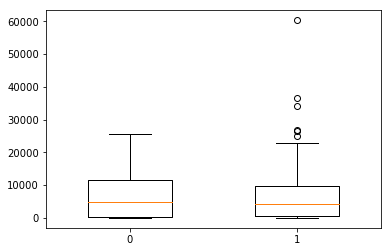

In [16]:
fig = plt.figure()
plt.boxplot([re78_0, re78_1],labels=['0','1'],widths=[0.5,0.5])
fig.suptitle('')

Looking at the boxplot, we can once again assess that the training program has no effect on the earning someone can make.

DESCRIBE TTEST HERE. EXPLAIN NULL AND ALTERNATIVE HYPOTHESIS

In [20]:
stats.ttest_ind(df_treat_0['re78'], df_treat_1['re78'], equal_var=False)

Ttest_indResult(statistic=0.93772969793931826, pvalue=0.34907665555666978)

# 2. A closer look at the data

The naive observations of part 1 let us conclude that the training program did not increase the real earnings people made after participating in it.
However, we know that in statistics, we cannot make conclusions so fast. We first have to verify if the caracteristics of people in the the control group are similar to the caracteristics of people in the treatment group.
We're then going to compare repartition of the caracteristics between the two groups (skin color, age, years of education, real earnings in 1974 and 1975...).

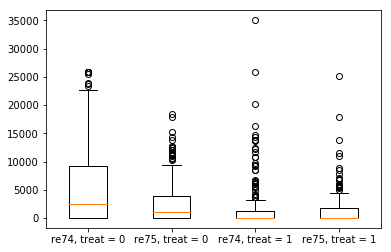

In [26]:
fig = plt.figure()
plt.boxplot([df_treat_0['re74'],df_treat_0['re75'],df_treat_1['re74'], df_treat_1['re75']],
            labels=['re74, treat = 0','re75, treat = 0','re74, treat = 1','re75, treat = 1'])
fig.suptitle('')

If we look at the real earnings in 1974-1975, we see that the samples are poorly distributed. The real earnings are significantly lower for the group that has participated in the training program. It indeed makes sense that only people that truly needed to increase their real earnings participated in such a training program. We thus get a bias in our dataset between people that participated and people that did not.

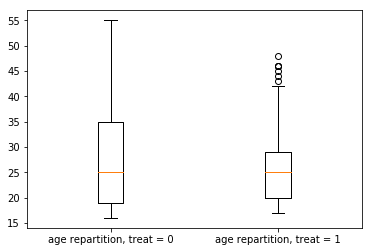

In [98]:
fig = plt.figure()
plt.boxplot([df_treat_0['age'], df_treat_1['age']], labels=['age repartition, treat = 0', 'age repartition, treat = 1'])
fig.suptitle('')

The age repartition is also unbalanced between the two groups. We have a larger distribution for ages in the control group. It seems that the treatment group is more composed of young people while the control group has a wider distribution over all age categories.

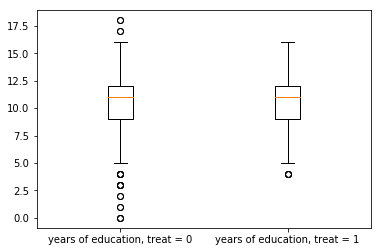

In [27]:
fig = plt.figure()
plt.boxplot([df_treat_0['educ'], df_treat_1['educ']], labels=['years of education, treat = 0', 'years of education, treat = 1'])
fig.suptitle('')

Years of education seem to be well distributed between the two groups.

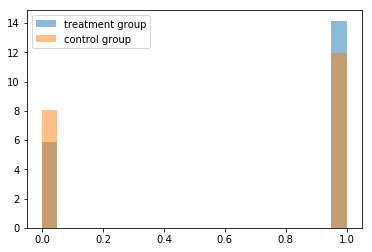

In [32]:
plt.hist(df_treat_1['nodegree'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_0['nodegree'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['treatment group','control group'])

We see that there are a bit less people that have a degree in the treatment group, but the difference do not seem to be significative.

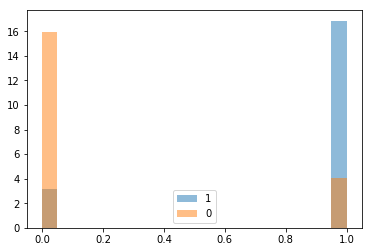

In [101]:
plt.hist(df_treat_1['black'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_0['black'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['1','0'])

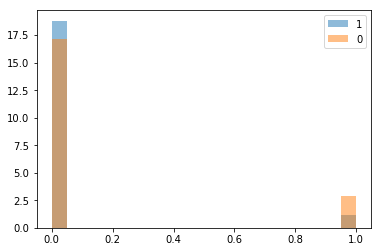

In [102]:
plt.hist(df_treat_1['hispan'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_0['hispan'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['1','0'])

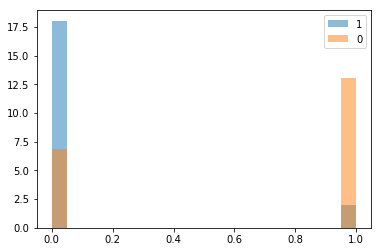

In [103]:
plt.hist(df_treat_1['white'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_0['white'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['1','0'])

Except the "hispanic" skin color, we can see that this caracteristic is poorly distributed between the treatment group and the control group.

We can conclude that our dataset is not equilibrated between control group and treatment group. We know that such a bad distribution can be a factor of biases generation in the results we get. We need to find a way to equilibrate the repartition of the caracteristics that influence the outcome to properly assess the efficiency of the training program.

# Propensity score matching

In order to compare the real efficiency of the training program, we need to construct a dataset in which people that participated in the training program, and people that did not, have similar caracteristics.
To do so, we're going to estimate propensity score for the variable "treat" (equals to 1 if people participated, 0 otherwise), performing a Logistic Regression on the other caracteristics (covariates).
This Logistic Regression will output an estimate of the probability a given subject has to have participated in the program, given the other caracteristics he presents.
We will then bind every subject from a group to a subject of the other, minimizing the sum of differenced of this probability value between the two groups.

In [100]:
covariates = df.drop(['id', 'treat','re78'], axis = 1)
treat = df['treat']

In [101]:
lr = lm.LogisticRegression(max_iter=10000,tol=1e-10)

In [102]:
precision = cross_val_score(lr, covariates, treat, cv=10, scoring="precision")
recall = cross_val_score(lr, covariates, treat, cv=10, scoring="recall")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.63 (+/- 0.47)
Recall: 0.70 (+/- 0.48)


The classification did not give a high precision, but it does not really matter as our goal is just to find pairs that present the same caracteristics in the two groups. In a way, it is convenient for us to have a low precision, since it means that the two groups contain subjects that present close caracteristics.

In [103]:
fit = lr.fit(covariates, treat)

In [104]:
probas = pd.DataFrame(fit.predict_proba(covariates))

In [105]:
probas.head()

,0,1
0,0.425470,0.574530
1,0.763559,0.236441
2,0.314610,0.685390
3,0.266562,0.733438
4,0.306000,0.694000


# Balancing the dataset via matching

In [106]:
print('control population size:', len(df_treat_0), '\ntreated population size:', len(df_treat_1))

control population size: 429 
treated population size: 185


Now that the Logistic Regression gave us estimations of propensity scores for every subjects, we can bind every subject of the treatment group (this group contains less subjects than the control one) with a subject of the control group, minimizing the distance in propensity score between the two.
We will finally get two groups of the same size (185).

To perform the binding, we're going to construct a bipartite graph (with the networkx library) and use the maximum matching algorithm. The first step is to construct a list of edges, that bind every vertices of a group to every vertices of the other, giving as weight 1-diff (diff being the difference in propensity score between the two subjects). We use this weight because we need the weight to be higher when the difference is lower to be able to use maximum matching algorithm.

In [107]:
def construct_bipartite_graph(df_1, df_2, probas):
    edges = []
    for i in df_1.index:
        for j in df_2.index:
            edges.append((i,j,1-abs(probas.loc[i][1] - probas.loc[j][1])))
    B = nx.Graph()
    B.add_nodes_from(df_1.index)
    B.add_nodes_from(df_2.index)
    B.add_weighted_edges_from(edges)
    
    return B

In [108]:
B = construct_bipartite_graph(df_treat_0, df_treat_1, probas)

Now that the bipartite graph is constructed, we can use the maximum matching algorithm directly implemented in the networkx library.

In [109]:
edges_matching = nx.algorithms.max_weight_matching(B)

We construct a new dataframe containing only the subjects that have been selected in the matching of the control group

In [110]:
df_match_control = df_treat_0.loc[edges_matching.keys()].dropna()

We now can perform a new analysis on the results we obtain.

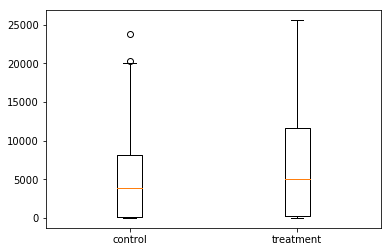

In [111]:
fig = plt.figure()
plt.boxplot([df_match_control['re78'], df_treat_0['re78']], labels=['control', 'treatment'])
fig.suptitle('')

In [112]:
stats.ttest_ind(df_match_control['re78'], df_treat_1['re78'], equal_var=False)

Ttest_indResult(statistic=-0.98383592159434718, pvalue=0.32588925302115068)

We see that once again, we do not conclude that the training program increased the real earnings in 1978.
To see if our method has been efficient, we check once again if the caracteristics are now well distributed between the two groups constructed.

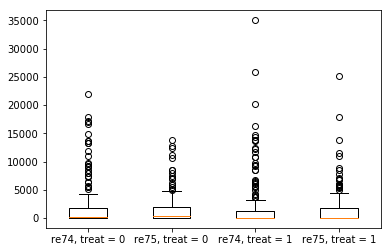

In [113]:
fig = plt.figure()
plt.boxplot([df_match_control['re74'],df_match_control['re75'],df_treat_1['re74'], df_treat_1['re75']],
            labels=['re74, treat = 0','re75, treat = 0','re74, treat = 1','re75, treat = 1'])
fig.suptitle('')

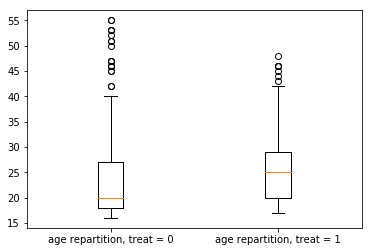

In [114]:
fig = plt.figure()
plt.boxplot([df_match_control['age'], df_treat_1['age']],
            labels=['age repartition, treat = 0', 'age repartition, treat = 1'])
fig.suptitle('')

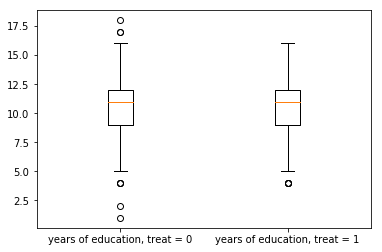

In [119]:
fig = plt.figure()
plt.boxplot([df_match_control['educ'], df_treat_1['educ']],
            labels=['years of education, treat = 0', 'years of education, treat = 1'])
fig.suptitle('')

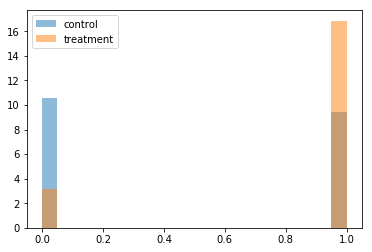

In [120]:
plt.hist(df_match_control['black'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_1['black'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['control','treatment'])

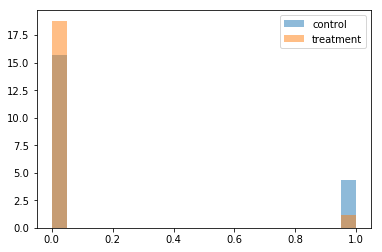

In [121]:
plt.hist(df_match_control['hispan'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_1['hispan'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['control','treatment'])

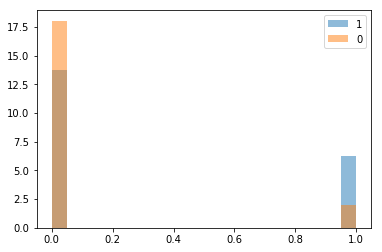

In [122]:
plt.hist(df_match_control['white'], bins = 20, alpha = 0.5,normed=True)
plt.hist(df_treat_1['white'], bins = 20, alpha = 0.5,normed=True)
plt.legend(['1','0'])

We observe that the matching allowed to give an equilibrated distribution over the caracteristics of the two groups except for the skin color caracteristic. We need to remove this heterogeneity between our groups to be sure the training has no effect.

# Balancing the groups further

In [126]:
df_BSC = df[df['black'] == 1]
df_HSC = df[df['hispan'] == 1]
df_WSC = df[df['white'] == 1]

covariates_BSC = df_BSC.drop(['id', 'treat','re78','black','hispan','white'], axis = 1)
treat_BSC = df_BSC['treat']
covariates_HSC = df_HSC.drop(['id', 'treat','black','re78','hispan','white'], axis = 1)
treat_HSC = df_HSC['treat']
covariates_WSC = df_WSC.drop(['id', 'treat','black','re78','hispan','white'], axis = 1)
treat_WSC = df_WSC['treat']

probas_BSC = pd.DataFrame(lr.fit(covariates_BSC,treat_BSC).predict_proba(covariates_BSC),index= df_BSC.index)
probas_HSC = pd.DataFrame(lr.fit(covariates_HSC,treat_HSC).predict_proba(covariates_HSC),index= df_HSC.index)
probas_WSC = pd.DataFrame(lr.fit(covariates_WSC,treat_WSC).predict_proba(covariates_WSC),index= df_WSC.index)

In [127]:
B_BSC = construct_bipartite_graph(df_BSC[df_BSC['treat'] == 0],df_BSC[df_BSC['treat'] == 1],probas_BSC)
B_HSC = construct_bipartite_graph(df_HSC[df_HSC['treat'] == 0],df_HSC[df_HSC['treat'] == 1],probas_HSC)
B_WSC = construct_bipartite_graph(df_WSC[df_WSC['treat'] == 0],df_WSC[df_WSC['treat'] == 1],probas_WSC)

edges_matching_BSC = nx.algorithms.max_weight_matching(B_BSC)
edges_matching_HSC = nx.algorithms.max_weight_matching(B_HSC)
edges_matching_WSC = nx.algorithms.max_weight_matching(B_WSC)

Ttest_indResult(statistic=-1.0741641216287965, pvalue=0.28429051866324007)

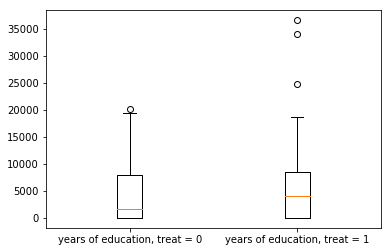

In [128]:
df_matching_BSC = df_BSC.loc[edges_matching_BSC.keys()].dropna()
fig = plt.figure()
plt.boxplot([df_matching_BSC[df_matching_BSC['treat'] == 0]['re78'], df_matching_BSC[df_matching_BSC['treat'] == 1]['re78']],
            labels=['re78 for black people, treat = 0', 're78 for black people, treat = 1'])
fig.suptitle('')
stats.ttest_ind(df_matching_BSC[df_matching_BSC['treat'] == 0]['re78'], 
                df_matching_BSC[df_matching_BSC['treat'] == 1]['re78'], equal_var=False)

Ttest_indResult(statistic=0.61225528064768031, pvalue=0.5472744820620139)

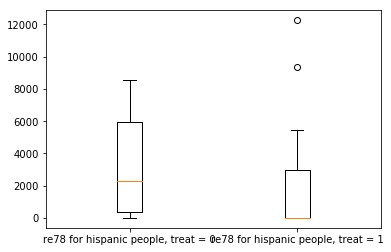

In [142]:
df_matching_HSC = df_HSC.loc[edges_matching_HSC.keys()].dropna()
fig = plt.figure()
plt.boxplot([df_matching_HSC[df_matching_HSC['treat'] == 0]['re78'], df_matching_HSC[df_matching_HSC['treat'] == 1]['re78']],
            labels=['re78 for hispanic people, treat = 0', 're78 for hispanic people, treat = 1'])
fig.suptitle('')
stats.ttest_ind(df_matching_HSC[df_matching_HSC['treat'] == 0]['re78'], 
                df_matching_HSC[df_matching_HSC['treat'] == 1]['re78'], equal_var=False)

In [145]:
probas_HSC[probas_HSC[1] >= 0.5] 

,0,1


Ttest_indResult(statistic=-1.5525523704544522, pvalue=0.12995450946134091)

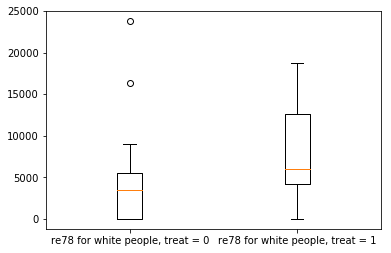

In [131]:
df_matching_WSC = df_WSC.loc[edges_matching_WSC.keys()].dropna()
fig = plt.figure()
plt.boxplot([df_matching_WSC[df_matching_WSC['treat'] == 0]['re78'], df_matching_WSC[df_matching_WSC['treat'] == 1]['re78']],
            labels=['re78 for white people, treat = 0', 're78 for white people, treat = 1'])
fig.suptitle('')
stats.ttest_ind(df_matching_WSC[df_matching_WSC['treat'] == 0]['re78'], 
                df_matching_WSC[df_matching_WSC['treat'] == 1]['re78'], equal_var=False)

In [135]:
final_matching_df = df_matching_BSC.append([df_matching_WSC])

Ttest_indResult(statistic=-1.5787780190659817, pvalue=0.11592912635321032)

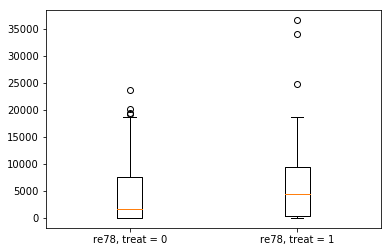

In [140]:
fig = plt.figure()
plt.boxplot([final_matching_df[final_matching_df['treat'] == 0]['re78'], final_matching_df[final_matching_df['treat'] == 1]['re78']],
            labels=['re78, treat = 0', 're78, treat = 1'])
fig.suptitle('')
stats.ttest_ind(final_matching_df[final_matching_df['treat'] == 0]['re78'], 
                final_matching_df[final_matching_df['treat'] == 1]['re78'], equal_var=False)